In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression

import joblib

In [4]:
df = pd.read_csv('train.csv')

In [5]:
df.shape

(381109, 12)

In [6]:
df.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')

In [7]:
df.info

<bound method DataFrame.info of             id  Gender  Age  Driving_License  Region_Code  Previously_Insured  \
0            1    Male   44                1         28.0                   0   
1            2    Male   76                1          3.0                   0   
2            3    Male   47                1         28.0                   0   
3            4    Male   21                1         11.0                   1   
4            5  Female   29                1         41.0                   1   
...        ...     ...  ...              ...          ...                 ...   
381104  381105    Male   74                1         26.0                   1   
381105  381106    Male   30                1         37.0                   1   
381106  381107    Male   21                1         30.0                   1   
381107  381108  Female   68                1         14.0                   0   
381108  381109    Male   46                1         29.0                   0

In [8]:
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [9]:
df.nunique()

id                      381109
Gender                       2
Age                         66
Driving_License              2
Region_Code                 53
Previously_Insured           2
Vehicle_Age                  3
Vehicle_Damage               2
Annual_Premium           48838
Policy_Sales_Channel       155
Vintage                    290
Response                     2
dtype: int64

<Axes: xlabel='count', ylabel='Gender'>

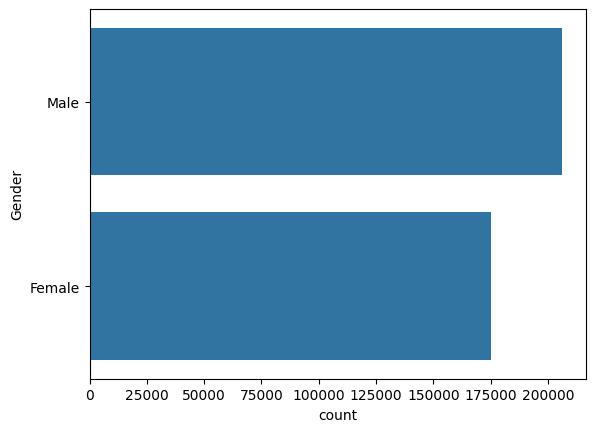

In [10]:
sns.countplot(data=df, y='Gender')

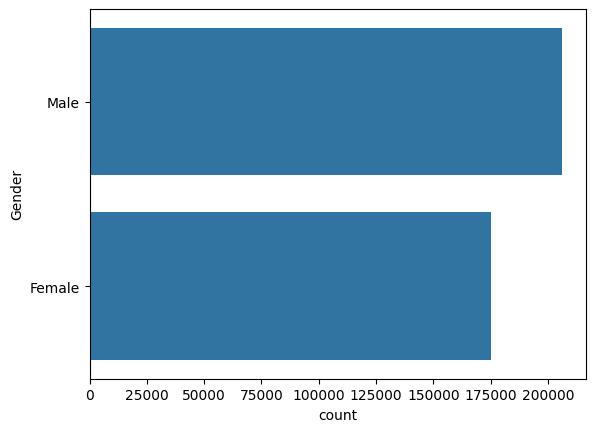

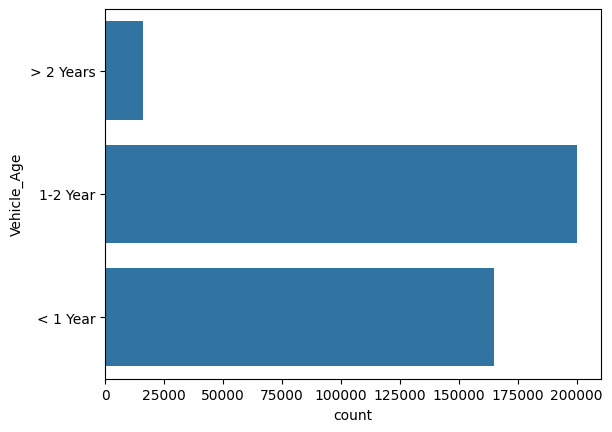

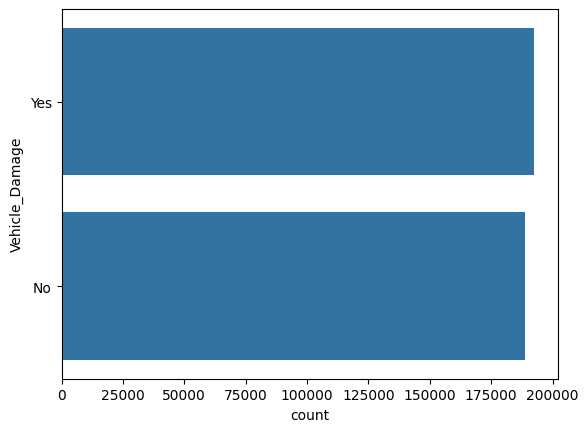

In [11]:
for col in df.select_dtypes(include='object').columns:
    sns.countplot(data=df,y=col)
    plt.show()

In [12]:
df['Age'].value_counts().sort_index()

Age
20     6232
21    16457
22    20964
23    24256
24    25960
      ...  
81       56
82       29
83       22
84       11
85       11
Name: count, Length: 66, dtype: int64

In [13]:
df['Age'].value_counts()

Age
24    25960
23    24256
22    20964
25    20636
21    16457
      ...  
81       56
82       29
83       22
84       11
85       11
Name: count, Length: 66, dtype: int64

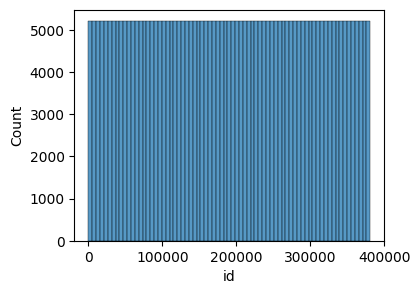

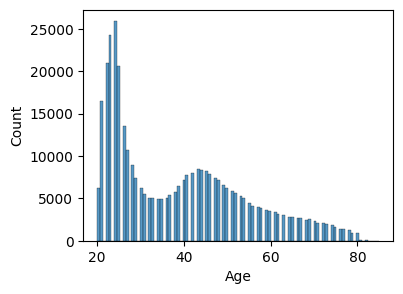

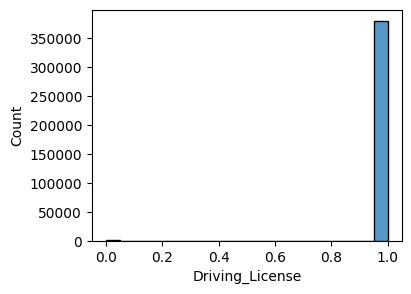

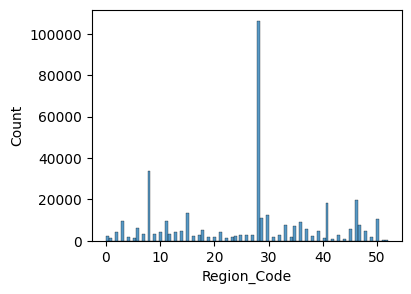

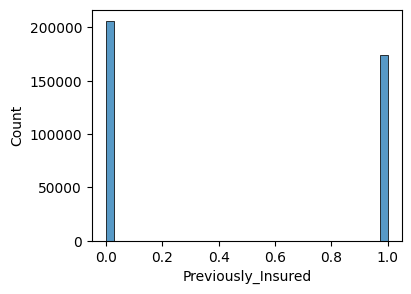

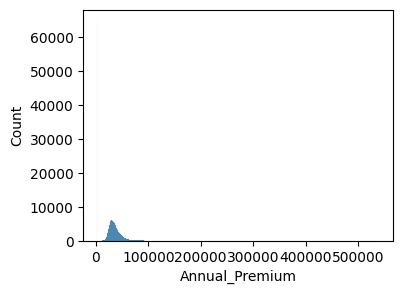

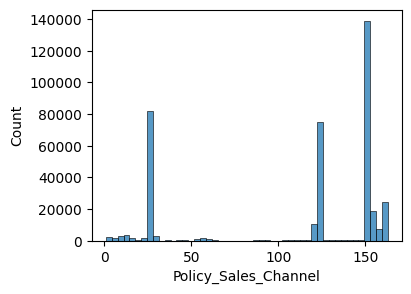

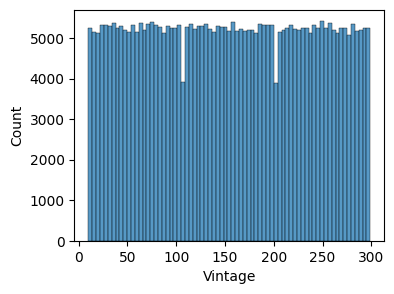

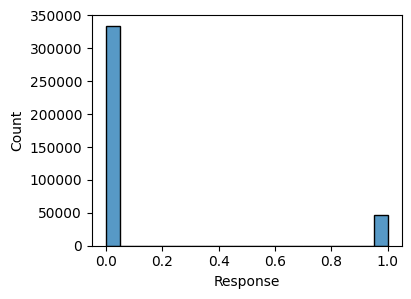

In [14]:
for col in df.drop(columns=['Gender']).select_dtypes(exclude='object').columns:
    plt.figure(figsize=(4,3))
    sns.histplot(data=df,x=col)
    plt.show()

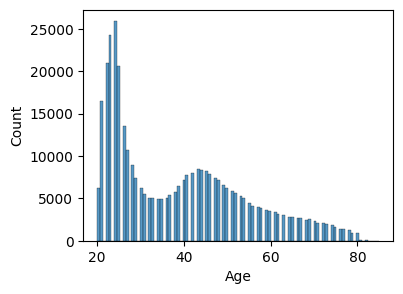

In [15]:
plt.figure(figsize=(4,3))
sns.histplot(data=df,x='Age')
plt.show()

In [16]:
df.dtypes

id                        int64
Gender                   object
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object

<function matplotlib.pyplot.show(close=None, block=None)>

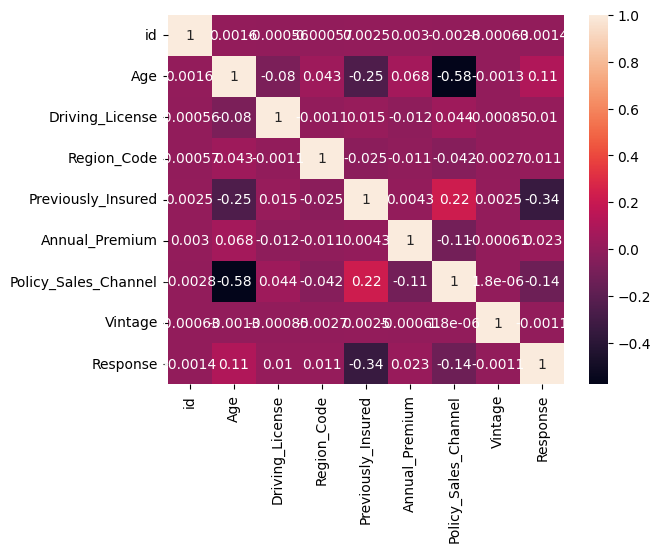

In [17]:
sns.heatmap(df.drop(columns=['Gender']).select_dtypes(exclude='object').corr(),annot=True)
plt.show

### Preprocessing


In [18]:
# check for missing values
df.isna().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [19]:
# check for any duplication

df.duplicated().sum()

np.int64(0)

In [21]:
target_col = 'Response'
target_col

'Response'

In [22]:
cat_cols = df.select_dtypes(include='object').columns
cat_cols

Index(['Gender', 'Vehicle_Age', 'Vehicle_Damage'], dtype='object')

In [23]:
ignore_cols = 'Gender'
ignore_cols

'Gender'

In [24]:
num_cols = df.drop(columns=ignore_cols).select_dtypes(exclude='object').columns
num_cols

Index(['id', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Annual_Premium', 'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')

In [25]:
df.nunique

<bound method DataFrame.nunique of             id  Gender  Age  Driving_License  Region_Code  Previously_Insured  \
0            1    Male   44                1         28.0                   0   
1            2    Male   76                1          3.0                   0   
2            3    Male   47                1         28.0                   0   
3            4    Male   21                1         11.0                   1   
4            5  Female   29                1         41.0                   1   
...        ...     ...  ...              ...          ...                 ...   
381104  381105    Male   74                1         26.0                   1   
381105  381106    Male   30                1         37.0                   1   
381106  381107    Male   21                1         30.0                   1   
381107  381108  Female   68                1         14.0                   0   
381108  381109    Male   46                1         29.0                 

In [26]:
# find which columns to encode

ALLOWED_MAX_UNIQUE_SIZE = 25
ucols_2_encd = []

for col in df.columns:
    ulen = df[col].nunique()
    #print(col, '=', ulen, df[col].unique())
    if ulen <= ALLOWED_MAX_UNIQUE_SIZE:
        ucols_2_encd.append(col)
        print(col, df[col].dtypes)

Gender object
Driving_License int64
Previously_Insured int64
Vehicle_Age object
Vehicle_Damage object
Response int64


In [27]:
ucols_2_encd

['Gender',
 'Driving_License',
 'Previously_Insured',
 'Vehicle_Age',
 'Vehicle_Damage',
 'Response']

In [28]:
ucols_2_encd.append('Service')
ucols_2_encd

['Gender',
 'Driving_License',
 'Previously_Insured',
 'Vehicle_Age',
 'Vehicle_Damage',
 'Response',
 'Service']

In [29]:
ucols_2_encd.pop()
ucols_2_encd

['Gender',
 'Driving_License',
 'Previously_Insured',
 'Vehicle_Age',
 'Vehicle_Damage',
 'Response']

In [30]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub=pd.read_csv('sample_submission_iA3afxn.csv')

In [31]:
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [32]:
tgt_col = ['Response']
ign_cols = ['id']
cat_cols = train.select_dtypes(include='object').columns  
num_cols = train.select_dtypes(exclude='object').columns 

In [33]:
print(tgt_col, ign_cols, cat_cols, num_cols, sep='\n')

['Response']
['id']
Index(['Gender', 'Vehicle_Age', 'Vehicle_Damage'], dtype='object')
Index(['id', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Annual_Premium', 'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')


In [34]:
train[cat_cols].head(2)

,Gender,Vehicle_Age,Vehicle_Damage
0,Male,> 2 Years,Yes
1,Male,1-2 Year,No


In [35]:
num_cols=train.select_dtypes(exclude='object').drop(columns=ign_cols+tgt_col).columns
train[num_cols].head(2)

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage
0,44,1,28.0,0,40454.0,26.0,217
1,76,1,3.0,0,33536.0,26.0,183


In [36]:
# create pipeline

cat_pipe_encode=Pipeline(
    steps=[
        ('impute_cat', SimpleImputer
         (strategy='most_frequent')),
        ('ohe',OneHotEncoder(handle_unknown='ignore'))
    ]
)    

In [37]:
# create pipeline of numerical

num_pipe_encode=Pipeline(
    steps=[
        ('impute_cat', SimpleImputer
         (strategy='most_frequent')),
        ('ohe',OneHotEncoder(handle_unknown='ignore'))
    ]
)    

In [38]:
# create map b/w the pipeline and the columns
preprocess = ColumnTransformer(
    transformers=[
        ('cat_encode', cat_pipe_encode, cat_cols),
         ('num_encode', num_pipe_encode, num_cols)
    ]
)

In [39]:
mymodel=LogisticRegression()

In [40]:
model_pipeline=Pipeline(
    steps=[
        ('preprocess', preprocess),
        ('mmodel', mymodel)
    ]
)

In [41]:
# split the train dataset to train and validation
X=train.drop(columns=ign_cols+tgt_col)
X.head(2)

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217
1,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183


In [42]:
y=train[tgt_col]
y.head(2)

,Response
0,1
1,0


In [43]:
train_X, val_X, train_y, val_y= train_test_split(X,y, test_size=0.1, random_state=42)
train_X.shape, val_X.shape, train_y.shape, val_y.shape

((342998, 10), (38111, 10), (342998, 1), (38111, 1))

In [44]:
train.shape, int(train.shape[0]*.9), int(train.shape[0]*.1)

((381109, 12), 342998, 38110)

In [45]:
import warnings
warnings.filterwarnings('ignore')

In [46]:
# fit the model
model_pipeline.fit(train_X, train_y)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat_encode',
                                                  Pipeline(steps=[('impute_cat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Gender', 'Vehicle_Age', 'Vehicle_Damage'], dtype='object')),
                                                 ('num_encode',
                                                  Pipeline(steps=[('impute_cat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Annual_Premium', 'Policy_Sales_Channel', 'Vintage'],
      dtype='object'))])),
                ('mmodel', LogisticRegression())])

In [47]:
# perform prediction with train itself
model_pipeline.predict(train_X)

array([0, 0, 0, ..., 0, 0, 0])

In [48]:
from sklearn.metrics import f1_score

# Make predictions
pred_train = model_pipeline.predict(train_X)  # Ensure `model_pipeline` is defined
pred_val = model_pipeline.predict(val_X)      # Correct the typo in `model.pipeline`

# Calculate and print F1 scores
print('Train F1 score:', f1_score(train_y, pred_train))
print('Val F1 score:', f1_score(val_y, pred_val))

Train F1 score: 0.2312057590888127
Val F1 score: 0.10209662716499544


In [49]:
sub['is_promoted'] = model_pipeline.predict(test)
sub.to_csv('submission_bharadwaj.csv', index=False)

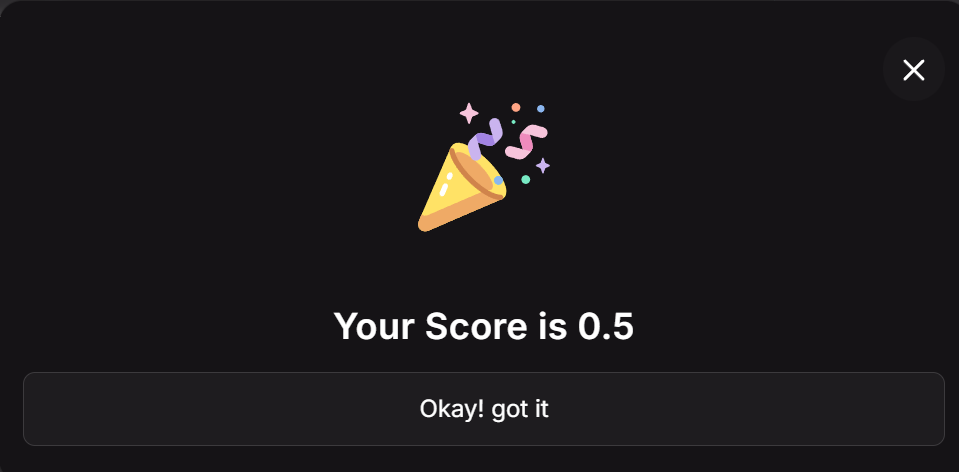

In [50]:
train.dtypes

id                        int64
Gender                   object
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object

In [51]:
# create the pickle file
joblib.dump(model_pipeline, 'promote_pipeline_model.pkl')

['promote_pipeline_model.pkl']

In [52]:
train.columns.to_frame()

,0
id,id
Gender,Gender
Age,Age
Driving_License,Driving_License
Region_Code,Region_Code
Previously_Insured,Previously_Insured
Vehicle_Age,Vehicle_Age
Vehicle_Damage,Vehicle_Damage
Annual_Premium,Annual_Premium
Policy_Sales_Channel,Policy_Sales_Channel


In [53]:
train.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')